In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pickle
import matplotlib.pyplot as plt

Accuracy with top 1 features: 0.7373
Accuracy with top 2 features: 0.9864
Accuracy with top 3 features: 0.9864
Accuracy with top 4 features: 0.9953
Accuracy with top 5 features: 0.9974
Accuracy with top 6 features: 0.9974
Accuracy with top 7 features: 0.9972
Accuracy with top 8 features: 0.9980
Accuracy with top 9 features: 0.9981
Accuracy with top 10 features: 0.9981
Accuracy with top 11 features: 0.9982


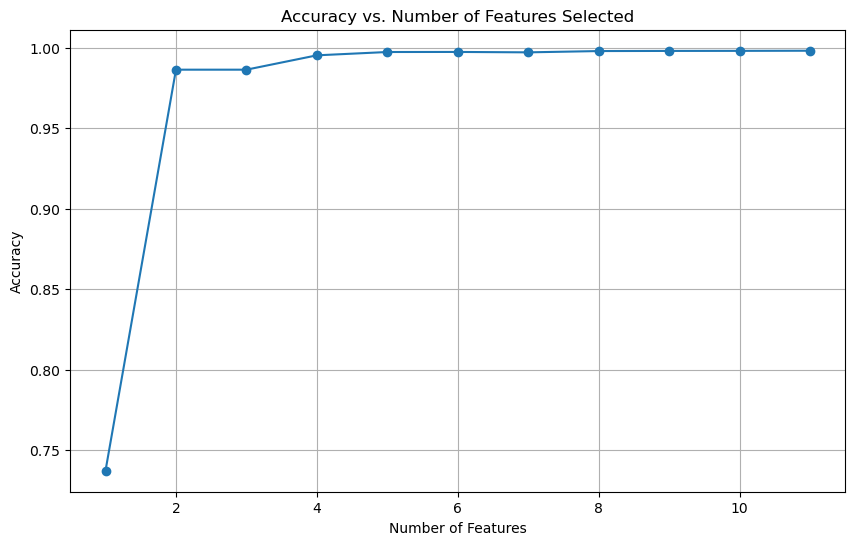

Best number of features: 11
Confusion Matrix:
 [[17144    43]
 [    0  6589]]
Accuracy: 0.9981914535666218
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     17187
           1       0.99      1.00      1.00      6589

    accuracy                           1.00     23776
   macro avg       1.00      1.00      1.00     23776
weighted avg       1.00      1.00      1.00     23776



In [33]:
# Load the dataset
dataset = pd.read_csv("cleaned_df_luxottica_churn_updated_0108.csv", index_col=None)

# Create a copy of the dataset for transformation
dataset_transformed = pd.get_dummies(dataset, drop_first=True)

# Separate features and target variable
X = dataset_transformed.drop('Churn_Yes', axis=1)
y = dataset_transformed['Churn_Yes']

# Apply Min-Max scaling to ensure non-negative values
min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)

# Initialize lists to store results
num_features = list(range(1, 12))  
accuracies = []

# Loop through different numbers of features
for k in num_features:
    # Select top k features using Chi-Square
    select_k_best = SelectKBest(score_func=chi2, k=k)
    X_selected = select_k_best.fit_transform(X_scaled, y)

    # Get the selected feature indices and names
    selected_features_indices = select_k_best.get_support(indices=True)
    selected_features = X.columns[selected_features_indices]

    # Create the final feature dataset with selected features
    X_final_selected = X[selected_features]
    
    # Apply Min-Max scaling to the selected features
    X_scaled_selected = min_max_scaler.fit_transform(X_final_selected)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled_selected, y, test_size=0.25, random_state=0)

    # Apply SMOTE to the training data only
    smote = SMOTE(random_state=0)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Initialize and train the Random Forest classifier
    classifier = RandomForestClassifier(random_state=0)
    classifier.fit(X_train_resampled, y_train_resampled)

    # Predict the test set results
    y_pred = classifier.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f'Accuracy with top {k} features: {accuracy:.4f}')

# Plot the results to visualize the accuracy for different numbers of features
plt.figure(figsize=(10, 6))
plt.plot(num_features, accuracies, marker='o')
plt.title('Accuracy vs. Number of Features Selected')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Choose the best number of features based on the highest accuracy
best_k = num_features[accuracies.index(max(accuracies))]
print(f'Best number of features: {best_k}')

# Select top features using Chi-Square with the best number of features
select_k_best = SelectKBest(score_func=chi2, k=best_k)
X_selected = select_k_best.fit_transform(X_scaled, y)

# Get the selected feature indices and names
selected_features_indices = select_k_best.get_support(indices=True)
selected_features = X.columns[selected_features_indices]

# Create the final feature dataset with selected features
X_final_selected = X[selected_features]

# Apply Min-Max scaling to the selected features
X_scaled_selected = min_max_scaler.fit_transform(X_final_selected)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_selected, y, test_size=0.25, random_state=0)

# Apply SMOTE to the training data only
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize and train the Random Forest classifier
classifier = RandomForestClassifier(random_state=0)
classifier.fit(X_train_resampled, y_train_resampled)

# Predict the test set results
y_pred = classifier.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display the results
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Classification Report:\n", class_report)

In [43]:
print("Selected features:",selected_features )

Selected features: Index(['Age', 'Price', 'Customer_Support_Interactions',
       'Customer_Satisfaction', 'Purchase_Frequency', 'Lifetime_Value',
       'Average_Order_Value', 'Number_of_Product_Categories_Purchased',
       'Loyalty_Program_Participation_Inactive',
       'Engagement_with_Promotions_Low', 'Engagement_with_Promotions_Medium'],
      dtype='object')


In [44]:
print("Selected features indices:",selected_features_indices )

Selected features indices: [   0    1    3    5    6   10   11   13 3299 3300 3301]


In [40]:
selected_features

Index(['Age', 'Price', 'Customer_Support_Interactions',
       'Customer_Satisfaction', 'Purchase_Frequency', 'Lifetime_Value',
       'Average_Order_Value', 'Number_of_Product_Categories_Purchased',
       'Loyalty_Program_Participation_Inactive',
       'Engagement_with_Promotions_Low', 'Engagement_with_Promotions_Medium'],
      dtype='object')

In [45]:
# Save the trained model to a file
model_filename = "finalized_model_random_forest.sav"
pickle.dump(classifier, open(model_filename, 'wb'))

# Example input for prediction (use scaled values)
example_input_unscaled = [[73, 502, 8, 7.9, 4, 6453.23,220, 1, 1, 1, 1]]
example_input = min_max_scaler.transform(example_input_unscaled)

# Load the saved model and make a prediction
loaded_model = pickle.load(open(model_filename, 'rb'))
prediction_result = loaded_model.predict(example_input)
prediction_result = prediction_result.astype(int)

print("Prediction result:", prediction_result)

Prediction result: [1]


C:\Users\AB92922\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
